# Group knockoff vs ungrouped knockoffs


In [11]:
# ml julia/1.8.4
# export JULIA_DEPOT_PATH="/home/groups/sabatti/.julia"

using Knockoffs
using LinearAlgebra
using Random
using StatsKit
using ToeplitzMatrices
using Distributions
using DelimitedFiles

function run_comparison(method::Symbol)
    outdir = "/home/groups/sabatti/group_knockoff_simulations/lasso_vs_marginal"
    isdir(outdir) || mkpath(outdir)
    group_props, group_fdrs, group_times = Float64[], Float64[], Float64[]

    # simulation parameters
    p = 200  # number of covariates
    k = 10   # number of true predictors
    μ = zeros(p)
    df = DataFrame(n=Int[], prop_mean=Float64[], prop_std=Float64[], 
        fdr_mean=Float64[], fdr_std=Float64[], time_mean=Float64[], time_std=Float64[])

    for rho in [0.1, 0.25, 0.5, 0.75]
        Σ = Matrix(SymmetricToeplitz(rho.^(0:(p-1)))) # true covariance matrix
        L = cholesky(Σ).L

        for sim in 1:100
            Random.seed!(sim)

            # simulate X
            Random.seed!(sim)
            X = randn(n, p) * L
            zscore!(X, mean(X, dims=1), std(X, dims=1)) # standardize columns of X

            # define groups
            groups = hc_partition_groups(X, cutoff=0.5)

            # simulate y
            βtrue = zeros(p)
            βtrue[1:k] .= rand(-1:2:1, k) .* 0.25
            shuffle!(βtrue)
            correct_snps = findall(!iszero, βtrue)
            correct_groups = groups[correct_snps] |> unique
            ϵ = randn(n)
            y = X * βtrue + ϵ;

            # group knockoffs
            t = @elapsed ko_filter = fit_lasso(y, X, μ, Σ, method=method, groups=groups, m=5)
            selected = ko_filter.selected[3]
            selected_snps = Int[]
            for g in selected
                append!(selected_snps, findall(isequal(g), groups))
            end
            prop = length(intersect(correct_snps, selected_snps)) / length(correct_snps)
            fdr = length(setdiff(selected, correct_groups)) / max(1, length(selected))
            println("$method sim $sim group-knockoff prop = $prop, FDR = $fdr, time=$t")
            push!(group_props, prop); push!(group_fdrs, fdr); push!(group_times, t)
            GC.gc();GC.gc();GC.gc();
        end
        push!(df, [n mean(group_props) std(group_props) mean(group_fdrs) std(group_fdrs) mean(group_times) std(group_times)])
    end
    CSV.write(joinpath(outdir, "grouped_$method.csv"), df)
end

function run_ungroup_knockoff(method::Symbol)
    outdir = "/home/groups/sabatti/group_knockoff_simulations/vs_ungrouped"
    isdir(outdir) || mkpath(outdir)
    regular_props, regular_fdrs, regular_times = Float64[], Float64[], Float64[]

    # simulation parameters
    p = 200  # number of covariates
    k = 10   # number of true predictors
    Σ = Matrix(SymmetricToeplitz(0.9.^(0:(p-1)))) # true covariance matrix
    μ = zeros(p)
    L = cholesky(Σ).L
    df = DataFrame(n=Int[], prop_mean=Float64[], prop_std=Float64[], 
        fdr_mean=Float64[], fdr_std=Float64[], time_mean=Float64[], time_std=Float64[])

    for n in 250:250:1000
        for sim in 1:100
            Random.seed!(sim)

            # simulate X
            Random.seed!(sim)
            X = randn(n, p) * L
            zscore!(X, mean(X, dims=1), std(X, dims=1)); # standardize columns of X

            # simulate y
            βtrue = zeros(p)
            βtrue[1:k] .= rand(-1:2:1, k) .* 0.25
            shuffle!(βtrue)
            correct_snps = findall(!iszero, βtrue)
            ϵ = randn(n)
            y = X * βtrue + ϵ;

            # group ME knockoffs
            t = @elapsed ko_filter = fit_lasso(y, X, μ, Σ, method=method, m=5)
            selected = ko_filter.selected[3]
            prop = length(intersect(correct_snps, selected)) / length(correct_snps)
            fdr = length(setdiff(selected, correct_snps)) / max(1, length(selected))
            println("Sim $sim nongroup-knockoff prop = $prop, FDR = $fdr, time=$t")
            push!(regular_props, prop); push!(regular_fdrs, fdr); push!(regular_times, t)
            GC.gc();GC.gc();GC.gc();
        end
        push!(df, [n mean(regular_props) std(regular_props) mean(regular_fdrs) std(regular_fdrs) mean(regular_times) std(regular_times)])
    end
    CSV.write(joinpath(outdir, "ungrouped_$method.csv"), df)
end

method = Symbol(ARGS[1])
group = parse(Bool, ARGS[2])
if group
    run_group_knockoff(method)
else
    if method == :sdp
        method = :sdp_ccd
    end
    run_ungroup_knockoff(method)
end

# run_group_knockoff(:maxent)
# run_ungroup_knockoff(:maxent)

maxent sim 1 group-knockoff prop = 0.5, FDR = 0.0, time=2.726765664
maxent sim 2 group-knockoff prop = 0.4, FDR = 0.0, time=2.415239919
maxent sim 1 group-knockoff prop = 0.8, FDR = 0.125, time=3.987610704
maxent sim 2 group-knockoff prop = 0.8, FDR = 0.0, time=4.475718271
maxent sim 1 group-knockoff prop = 0.5, FDR = 0.2, time=6.569301921
maxent sim 2 group-knockoff prop = 0.9, FDR = 0.0, time=6.977446886
maxent sim 1 group-knockoff prop = 1.0, FDR = 0.1, time=7.45064572
maxent sim 2 group-knockoff prop = 0.8, FDR = 0.0, time=7.512386119
Sim 1 nongroup-knockoff prop = 0.0, FDR = 0.0, time=1.205522695
Sim 2 nongroup-knockoff prop = 0.0, FDR = 0.0, time=1.23694007
Sim 1 nongroup-knockoff prop = 0.2, FDR = 0.0, time=2.818011303
Sim 2 nongroup-knockoff prop = 0.3, FDR = 0.0, time=3.273723321
Sim 1 nongroup-knockoff prop = 0.5, FDR = 0.16666666666666666, time=5.038721666
Sim 2 nongroup-knockoff prop = 0.4, FDR = 0.0, time=5.690682427
Sim 1 nongroup-knockoff prop = 0.7, FDR = 0.222222222222

"/home/groups/sabatti/group_knockoff_simulations/vs_ungrouped/ungrouped_maxent.csv"

Submission script

In [12]:
function run_repeats()
    simdir = "/home/groups/sabatti/group_knockoff_simulations"
    outdir = "/home/groups/sabatti/group_knockoff_simulations/vs_ungrouped"
    for method in ["equi", "sdp", "maxent", "mvr"], group in [true, false]
        # create .sh file to submit jobs
        filename = "submit.sh"
        open(filename, "w") do io
            println(io, "#!/bin/bash")
            println(io, "#")
            println(io, "#SBATCH --job-name=vs")
            println(io, "#")
            println(io, "#SBATCH --time=24:00:00")
            println(io, "#SBATCH --cpus-per-task=1")
            println(io, "#SBATCH --mem-per-cpu=12G")
            println(io, "#SBATCH --partition=owners,normal,candes,zihuai")
            println(io, "#SBATCH --output=$(outdir)/slurms/slurm-%j.out")
            println(io, "")
            println(io, "#save job info on joblog:")
            println(io, "echo \"Job \$JOB_ID started on:   \" `hostname -s`")
            println(io, "echo \"Job \$JOB_ID started on:   \" `date `")
            println(io, "")
            println(io, "# load the job environment:")
            println(io, "module load julia/1.8.4")
            println(io, "export JULIA_DEPOT_PATH=\"/home/groups/sabatti/.julia\"")
            println(io, "")
            println(io, "# run code")
            println(io, "echo 'julia $(simdir)/run_vs_ungrouped.jl $method $group'")
            println(io, "julia $(simdir)/run_vs_ungrouped.jl $method $group")
            println(io, "")
            println(io, "#echo job info on joblog:")
            println(io, "echo \"Job \$JOB_ID ended on:   \" `hostname -s`")
            println(io, "echo \"Job \$JOB_ID ended on:   \" `date `")
            println(io, "#echo \" \"")
        end
        # submit job
        run(`sbatch $filename`)
        rm(filename, force=true)
    end
end
run_repeats()


Submitted batch job 18651419
Submitted batch job 18651420
Submitted batch job 18651421
Submitted batch job 18651423
Submitted batch job 18651424
Submitted batch job 18651425
Submitted batch job 18651426
Submitted batch job 18651427


## Make plots

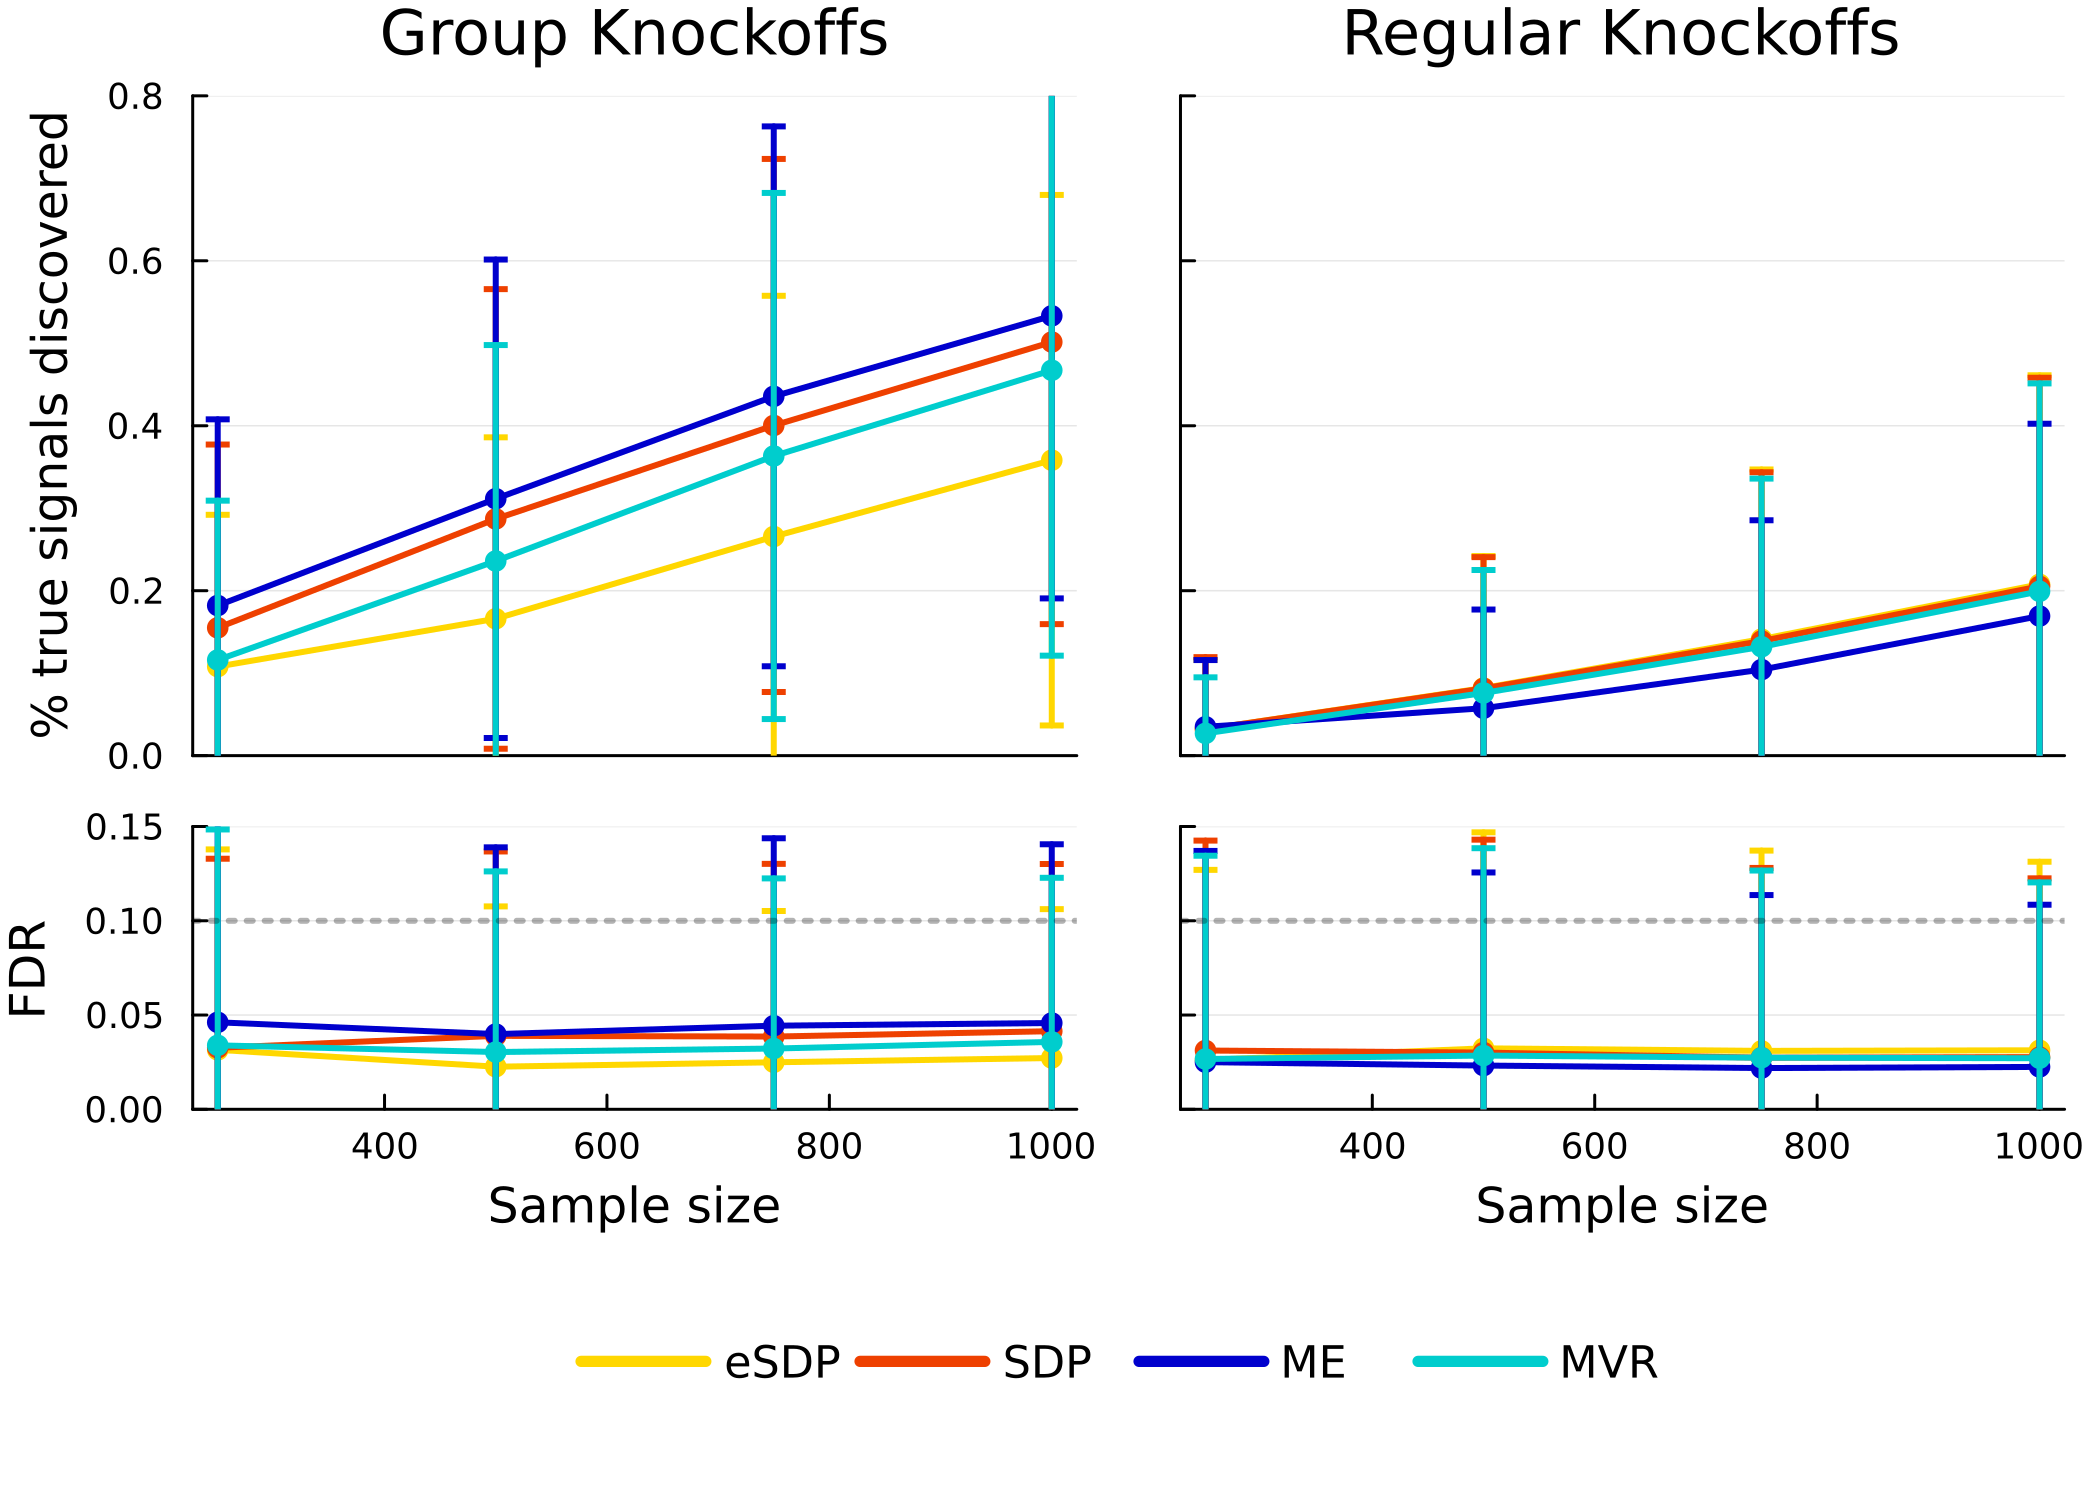

┌ Warning: n° of legend_column=5 is larger than n° of series=4
└ @ Plots /home/groups/sabatti/.julia/packages/Plots/rz1WP/src/backends/gr.jl:1235
GKS: Rectangle definition is invalid in routine SET_VIEWPORT


In [4]:
using StatsBase
using Plots
using CSV
using DataFrames
gr(fmt=:png)
global my_colors = ["gold", "orangered2", "mediumblue", "cyan3"]

function make_plot(group::Bool)
    outdir = "/home/groups/sabatti/group_knockoff_simulations/vs_ungrouped"
    methods = group ? ["equi", "sdp", "maxent", "mvr"] : ["equi", "sdp_ccd", "maxent", "mvr"]
    labels = ["Equi", "SDP", "ME", "MVR"]

    title = group ? "Group Knockoffs" : "Regular Knockoffs"
    power_plt = plot(; title=title)
    fdr_plt = plot(; xgrid=false)
    for (color, label, method) in zip(my_colors, labels, methods)
        outfile = group ? "grouped_$method.csv" : "ungrouped_$method.csv"
        result = CSV.read(joinpath(outdir, outfile), DataFrame)
        ns = result[!, "n"]
        
        if group
            prop_mean = result[!, "prop_mean"]
            prop_std = result[!, "prop_std"]
            plot!(power_plt, ns, prop_mean, yerr=prop_std, xtick=false, shape=:circle, 
                ylabel="% true signals discovered", label=label, w=2, ylim=(0, 0.8), title=title, 
                markerstrokecolor=color, color=color)

            fdr_mean = result[!, "fdr_mean"]
            fdr_std = result[!, "fdr_std"]
            plot!(fdr_plt, ns, fdr_mean, yerr=fdr_std, xlabel="Sample size", ylabel="FDR", 
                label="equi", w=2, ylim=(0, 0.15), shape=:circle, 
                markerstrokecolor=color, color=color)
        else
            prop_mean = result[!, "prop_mean"]
            prop_std = result[!, "prop_std"]
            plot!(power_plt, ns, prop_mean, yerr=prop_std, xtick=false, shape=:circle,
                label=label, w=2, ylim=(0, 0.8), title=title, ytick=(0.0:0.2:0.8, ["","","","",""]),
                markerstrokecolor=color, color=color, legend=false)

            fdr_mean = result[!, "fdr_mean"]
            fdr_std = result[!, "fdr_std"]
            plot!(fdr_plt, ns, fdr_mean, yerr=fdr_std, xlabel="Sample size", 
                ytick=(0.0:0.05:0.15, ["","","",""]),
                label="equi", w=2, ylim=(0, 0.15), shape=:circle, markerstrokecolor=color, color=color)
        end
    end
    hline!(fdr_plt, [0.1], label = "target FDR", linestyle=:dot, w=2, color=:black, legend=false, alpha=0.3)

#     power_plt = plot(ns, equi_powers_mean, yerr=equi_powers_std, xtick=false, shape=:circle,
#         ylabel="power", label="equi", w=2, ylim=(0, 1.0), title=title, markerstrokecolor=:auto, capsize = 0)
#     plot!(ns, sdp_powers_mean, yerr=sdp_powers_std, label = "SDP", w=2, shape=:circle, markerstrokecolor=:auto, capsize = 0)
#     plot!(ns .- 1.5, maxent_powers_mean, yerr=maxent_powers_std, label = "ME", w=2, shape=:circle, markerstrokecolor=:auto, capsize = 0)
#     plot!(ns .+ 1.5, mvr_powers_mean, yerr=mvr_powers_std, label = "MVR", w=2, shape=:circle, markerstrokecolor=:auto, capsize = 0)

#     fdr_plt = plot(ns, equi_fdrs_mean, xlabel="Sample size", yerr=equi_fdrs_std, 
#         ylabel="FDR", label="equi", w=2, ylim=(0, 0.15), shape=:circle, markerstrokecolor=:auto, )
#     plot!(ns, sdp_fdrs_mean, label = "SDP", w=2, shape=:circle, yerr=sdp_fdrs_std, markerstrokecolor=:auto)
#     plot!(ns, maxent_fdrs_mean, label = "ME", w=2, shape=:circle, yerr=maxent_fdrs_std, markerstrokecolor=:auto)
#     plot!(ns, mvr_fdrs_mean, label = "MVR", w=2, shape=:circle, yerr=mvr_fdrs_std, markerstrokecolor=:auto)
    
    return power_plt, fdr_plt
end

# make main plot
group_power_plt, group_fdr_plt = make_plot(true)
plt1 = plot(group_power_plt, group_fdr_plt, layout = grid(2, 1, heights=[0.7 ,0.3]), legend=false)
ungroup_power_plt, ungroup_fdr_plt = make_plot(false)
plt2 = plot(ungroup_power_plt, ungroup_fdr_plt, layout = grid(2, 1, heights=[0.7 ,0.3]))
combined = plot(plt1, plt2)

# separate plot for legend
n = 5
labels = ["eSDP" "SDP" "ME" "MVR"]
lstyles = [:solid :solid :solid :solid]
legend_plt = plot(2:n,2:n, lims=(0,1), legendfontsize=10, legend=:outerbottom, 
    legendcolumns=n, frame=:none, fg_color_legend = nothing, w=3,
    label=labels[1], color=my_colors[1], linestyle=lstyles[1])
plot!(legend_plt, 2:n, 2:n, label=labels[2], color=my_colors[2], w=3,linestyle=lstyles[2])
plot!(legend_plt, 2:n, 2:n, label=labels[3], color=my_colors[3], w=3,linestyle=lstyles[3])
plot!(legend_plt, 2:n, 2:n, label=labels[4], color=my_colors[4], w=3,linestyle=lstyles[4])
# plot!(legend_plt, 2:n, 2:n, label="target FDR", color="black", alpha=0.3, w=2, linestyle=:dot)
annotate!(legend_plt, -2.2, -0.5, "Sample size", :black)

# combine plots
plt = plot(combined, legend_plt, size=(700, 500), layout = grid(2, 1, heights=[0.89, 0.11]), dpi=300)


In [5]:
savefig(plt, "/home/users/bbchu/knockoffs/plots/vs_ungrouped.pdf")

┌ Warning: n° of legend_column=5 is larger than n° of series=4
└ @ Plots /home/groups/sabatti/.julia/packages/Plots/rz1WP/src/backends/gr.jl:1235
GKS: Rectangle definition is invalid in routine SET_VIEWPORT


"/home/users/bbchu/knockoffs/plots/vs_ungrouped.pdf"